In [1]:
import argparse
import numpy as np

import data
import equations
from gp_utils import run_gp_ode
from interpolate import get_ode_data
import pickle
import os
import time
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
from gp_utils import *

def gp_to_pysym(f_star, ode):
    VarDict = ode.get_var_dict()
    f_star_list, var_list, coef_list = parse_program_to_list(f_star.program)
    f_star_infix = generator.Generator.prefix_to_infix(f_star_list, variables=var_list, coefficients=coef_list)
    f_star_infix2 = f_star_infix.replace('{', '').replace('}', '')
    if f_star_infix2 == f_star_infix:
        f_star_sympy = generator.Generator.infix_to_sympy(f_star_infix, VarDict, "simplify")
        return f_star_sympy

    f_star_sympy = generator.Generator.infix_to_sympy(f_star_infix2, VarDict, "simplify")
    return f_star_sympy

def std_RMSE(err_sq):
    rmse_list = []
    for i in range(500):
        new_err = err_sq[np.random.randint(0, len(err_sq), err_sq.shape)]
        rmse_itr = np.sqrt(np.mean(new_err))
        rmse_list.append(rmse_itr)
    return np.std(np.array(rmse_list))

In [3]:
dim_x, x_id, n_sample = 2, 0, 200
seed_s, seed_e = 0, 100
ode_name = 'real'
dg = data.DataGeneratorReal(dim_x, n_sample)

yt = dg.generate_data()
ode = equations.RealODEPlaceHolder()
ode_data, X_ph, y_ph, t_new = get_ode_data(yt, x_id, dg, ode)


## SR-T

In [4]:
np.random.seed(10)

In [5]:
path_base = 'results/{}/sample-{}/dim-{}/'.format(ode_name, n_sample, dim_x)


In [6]:
res_list = []
for s in range(seed_s, seed_e):
    if x_id == 0:
        path = path_base + 'grad_seed_{}.pkl'.format(s)
    else:
        path = path_base + 'grad_x_{}_seed_{}.pkl'.format(x_id, s)

    try:
        with open(path, 'rb') as f:
            res = pickle.load(f)
        res_list.append(res)
    except FileNotFoundError:
        pass

In [7]:
f_sym_list = [x['f_hat'] for x in res_list]
f_hat_list = [x['model'] for x in res_list]
fitness_list = [x['model'].oob_fitness_ for x in res_list]
# fitness_list = [x['model'].fitness_ for x in res_list]

In [8]:
# Counter(f_sym_list)

In [9]:
best_fit = fitness_list.index(min(fitness_list))

In [10]:
best_fit

42

In [11]:
f_sym_list[best_fit]

X0*log(X0**2)*log(X1**2)*log(X0*X1 + 2*X1)

In [12]:
ind = best_fit
def ones_func(x):
    return 1.

f_list = []
for i in range(2):
    if i == 0:
        f_list.append(f_hat_list[ind].execute)
    else:
        f_list.append(ones_func)

ode_hat = equations.InferredODE(2, f_hat_list=f_list, T=dg.T)
dg_hat = data.DataGenerator(ode_hat, dg.T, freq=dg.freq, n_sample=10, noise_sigma=0., init_low=(0.99, 0.01),
                            init_high=(1., 0.))



(0.0, 1.1)

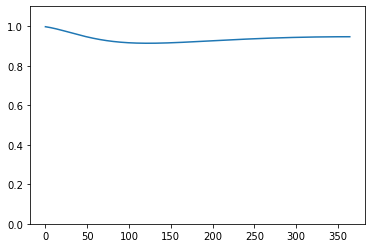

In [13]:
plt.plot(dg_hat.xt[:, 0, 0])
plt.ylim(0,1.1)

In [14]:
x_true = dg.yt_test[:, :, 0]
x_pred = dg_hat.xt[:, 0:1, 0]
mask = dg.mask_test

In [15]:
np.sqrt(np.sum((x_true - x_pred)**2 * mask) / np.sum(mask))

0.7478554771888622

In [16]:
std_RMSE((x_true - x_pred)**2)

0.0006102678663462805

## D-CODE

In [17]:
np.random.seed(10)

In [18]:
path_base = 'results_vi/{}/sample-{}/dim-{}/'.format(ode_name, n_sample, dim_x)


In [19]:
res_list = []
for s in range(seed_s, seed_e):
    if x_id == 0:
        path = path_base + 'grad_seed_{}.pkl'.format(s)
    else:
        path = path_base + 'grad_x_{}_seed_{}.pkl'.format(x_id, s)

    try:
        with open(path, 'rb') as f:
            res = pickle.load(f)
        res_list.append(res)
    except FileNotFoundError:
        pass

In [20]:
f_sym_list = [x['f_hat'] for x in res_list]
f_hat_list = [x['model'] for x in res_list]
fitness_list = [x['model'].oob_fitness_ for x in res_list]
best_fit = fitness_list.index(min(fitness_list))

In [28]:
f_sym_list[0]

C*X0*X1**C + log(X1)

In [22]:
ind = 0
def ones_func(x):
    return 1.

f_list = []
for i in range(2):
    if i == 0:
        f_list.append(f_hat_list[ind].execute)
    else:
        f_list.append(ones_func)

ode_hat = equations.InferredODE(2, f_hat_list=f_list, T=dg.T)
dg_hat = data.DataGenerator(ode_hat, dg.T, freq=dg.freq, n_sample=10, noise_sigma=0., init_low=(0.99, 0.01),
                            init_high=(1., 0.))



(0.0, 1.1)

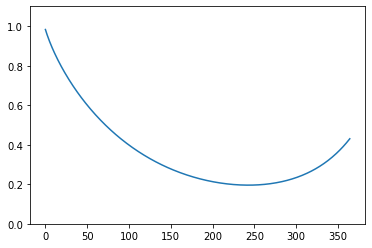

In [23]:
plt.plot(dg_hat.xt[:, 0, 0])
plt.ylim(0,1.1)

In [24]:
x_true = dg.yt_test[:, :, 0]
x_pred = dg_hat.xt[:, 0:1, 0]
mask = dg.mask_test

In [25]:
np.sqrt(np.sum((x_true - x_pred)**2 * mask) / np.sum(mask))

0.23663014668704674

In [26]:
std_RMSE((x_true - x_pred)**2)

0.0003295407196635378